# 2DSegmentNet-v1
* Start with SegmentNet-v5 and convert it to a 2D Model
* Observation: If we have too many segments (15) model trains but the segments overlap. needs investigation.
* Finding: The above problem was due to early stopping and large learning rate. As we go above 11 segments we need to drop learning rate to .0001 and train longer (epocs > 3000).
* for 13 segments the loss at 9000 epocs and .0001 lr goes down to .0021 but you see three segments not aligned and cancelling each other. This is a perfect example where extra segments don't really help.
* 8 segments is more than enough looks like for this shape

## Initialization

In [18]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

In [19]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


# Functions we are trying to approximate

In [20]:
np.random.seed(10)

# y = ax^4 + bx^3 + cx^2 + dx + f
def f_quarticn(x):
    a = -0.0179516
    b = 0.331323
    c = -1.63398
    d = 1.01107
    f = 5.73434
    x = x + 1
    return a*x**4 + b*x**3 + c*x**2 + d*x + f

def f_quartic(x):
    a = -0.0179516
    b = 0.331323
    c = -1.63398
    d = 1.01107
    f = 5.73434
    return a*x**4 + b*x**3 + c*x**2 + d*x + f
    
def f2_quartic(x):
    y = np.zeros([2,x.shape[0]])
    y[0] = f_quartic(x)
    y[1] = f_quartic(x+1)
    return y.T

def f_inv_quartic(x):
    return 7 - f_quartic(x)
    
def f_semicircle(x):
    maxX = x.max()
    minX = x.min()
    radius = (maxX - minX)/2 
    center = (maxX + minX)/2 
    y = np.sqrt(np.abs(radius**2 - (x-center)**2))
    return y
    
def frand(y):
    return y + y*np.random.uniform(-0.1, 0.1, y.shape).astype('f')

def normalize(x,y):
    x_normalized = torch.nn.functional.normalize(x, dim=0)
    y_normalized = torch.nn.functional.normalize(y, dim=0)

    return x_normalized, y_normalized

## Visualize functions

torch.Size([250]) (250, 2)
(250, 2)


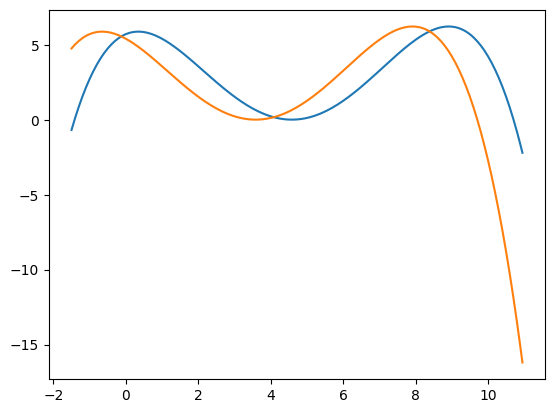

In [21]:
xs = torch.arange(-1.5, 11., .05)
ys = f2_quartic(xs)
print(xs.shape, ys.shape)
plt.plot(xs, ys[:,0])
plt.plot(xs, ys[:,1])
print(ys.shape)
plt.show()

# Model definition

## model test dev

In [22]:
# Test - how to initialize 2D x array with same values 
segment_features = 6
out_features = 1
x_init = torch.arange(0, 1 + 1./segment_features, 1./segment_features)
# make sure x_init shape is segment + 1 as it can be more for some segment_features like 6
x_init = x_init[0:1+segment_features]
x_2dinit = torch.Tensor(out_features, segment_features + 1)
x_2dinit[:] = x_init.unsqueeze(0)
x = torch.Tensor(x_2dinit)
print(x.shape, x_init.unsqueeze(0).shape)
# slightly modify second row
if(out_features > 1):
    x[1, 1:-1] = x[1, 1:-1] + .1
print(x)

torch.Size([1, 7]) torch.Size([1, 7])
tensor([[0.0000, 0.1667, 0.3333, 0.5000, 0.6667, 0.8333, 1.0000]])


In [23]:
x_in = np.array([.1, .2, .3, .4, .5, .6, .7, .8, .9])
x_in = torch.tensor(x_in.reshape(x_in.shape[0],1), dtype=torch.float32)
x_in.shape

torch.Size([9, 1])

In [24]:
#forward
lt = torch.lt(x_in.unsqueeze(1).unsqueeze(1), x[:, 1:]) 
ge = torch.ge(x_in.unsqueeze(1).unsqueeze(1), x[:, :-1]) 
mask = (lt & ge)
#print(mask)
y = torch.Tensor(out_features, segment_features + 1)
#y = copy(x)
if(out_features > 1):
    y[0,:] = x[0, :]
    y[1,:] = x[1,:]*2
else:
    y[0,:] = x[0, :]
print ("x=",x)
print("y=",y)
ratio = (y[:,1:]-y[:,:-1])/(x[:,1:]-x[:,:-1])
print("ratio=",ratio)
y_pred = (x_in.unsqueeze(1).unsqueeze(1) -  x[:,:-1])*mask*ratio + mask * y[:,:-1]
print(y_pred.shape, y_pred.sum(dim=3).squeeze(2).shape)
print("ypred=",y_pred.sum(dim=3).squeeze(2))

x= tensor([[0.0000, 0.1667, 0.3333, 0.5000, 0.6667, 0.8333, 1.0000]])
y= tensor([[0.0000, 0.1667, 0.3333, 0.5000, 0.6667, 0.8333, 1.0000]])
ratio= tensor([[1., 1., 1., 1., 1., 1.]])
torch.Size([9, 1, 1, 6]) torch.Size([9, 1])
ypred= tensor([[0.1000],
        [0.2000],
        [0.3000],
        [0.4000],
        [0.5000],
        [0.6000],
        [0.7000],
        [0.8000],
        [0.9000]])


## Model 

In [25]:
#Code modified for x,y parameters

class TwoDSegmentNet(nn.Module):
    def __init__(self, out_features, segment_features):
        super(TwoDSegmentNet, self).__init__()
        self.segment_features = segment_features
        self.out_features = out_features

        #Initialize x coordinates between 0-1 so segments are equal size
        x_init = torch.Tensor(np.linspace(0, 1, segment_features+1))
        # make a 2D init tensor
        x_2dinit = torch.Tensor(out_features, segment_features + 1)
        # Update the x_2dinit tensor with the repeated values
        x_2dinit[:] = x_init.unsqueeze(0)
        # initialize all rows of x
        self.x = nn.Parameter(torch.Tensor(x_2dinit))
        #y can be zeros
        self.y = nn.Parameter(torch.Tensor(out_features, segment_features + 1))

    def custom_init(self, x_min, x_max):
        x_init = torch.Tensor(np.linspace(x_min, x_max, self.segment_features+1))
        # make a 2D init tensor
        x_2dinit = torch.Tensor(self.out_features, self.segment_features + 1)
        # Update the x_2dinit tensor with the repeated values
        x_2dinit[:] = x_init.unsqueeze(0)
        # initialize all rows of x
        self.x = nn.Parameter(torch.Tensor(x_2dinit))
    
    def forward(self, x_in):
        # x_in.shape = [N, 1]
        x_in_4d =  x_in.unsqueeze(1).unsqueeze(1)     
        # x_in_4d.shape =  [N, 1, 1, 1] 
        # to find out if x is between segments
        lt = torch.lt(x_in_4d, self.x[:, 1:]) 
        ge = torch.ge(x_in_4d, self.x[:, :-1]) 
        mask = (lt & ge)

        # This mask doesn't include x where x is below 1st segment start or after last segment end
        # we create new mask to capture the x values beyond segments
        mask_lt = torch.lt(x_in_4d,self.x[:, 0:1])
        mask_ge = torch.ge(x_in_4d,self.x[:, -1:])
        # then do OR with mask so these are included for prediction.
        mask[:,:,:,-1:] = mask[:,:,:,-1:] | mask_ge
        mask[:,:,:, :1] = mask[:,:,:, :1] | mask_lt

        # Ratio is the segment (y2-y1)/(x2-x1) ratio 
        # consider each segment as a right triangle so we can find new y-y1 as ratio of x-x1
        ratio = (self.y[:,1:]-self.y[:,:-1])/(self.x[:,1:]-self.x[:,:-1])

        ypred = (x_in_4d -  self.x[:,:-1])*mask*ratio + mask * self.y[:,:-1]
        ypred = ypred.sum(dim=3)
        #print("ypred.shape:",ypred.shape)
        return ypred
            
    def extra_repr(self) -> str:
        return f'out_features={self.out_features}, segment_features={self.segment_features}'

# Data Loaders

In [28]:
from torch.utils.data.dataloader import DataLoader

class InfiniteRandomDataLoader:

    def __init__(self, dataset, loss, replacement=True, **kwargs):
        train_sampler = torch.utils.data.RandomSampler(dataset, replacement=replacement, num_samples=int(1e10))
        self.train_loader = DataLoader(dataset, sampler=train_sampler, **kwargs)
        self.data_iter = iter(self.train_loader)

    def next(self):
        try:
            batch = next(self.data_iter)
        except StopIteration: # this will technically only happen after 1e10 samples... (i.e. basically never)
            self.data_iter = iter(self.train_loader)
            batch = next(self.data_iter)
        return batch


# Model Training with random data loader

# Init

In [29]:
# init training
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy

torch.manual_seed(10)

#model = OneLayerSegmentNet(1, 4)
model = TwoDSegmentNet(2, 7)
criterion = nn.MSELoss(reduction='sum')

# Capture params after initialization
model_params = []
#model_param_grads = []
model_params.append(copy.deepcopy(model.state_dict()))

#create ys data from scratch so we can sort xs as needed - made no different with randomloader for segmentnet
f = f2_quartic # select data function
xs = np.arange(-1.5, 11., .05)
ys = f(xs)
print(xs.shape, ys.shape)

x = torch.tensor((xs).reshape(xs.shape[0],1), dtype=torch.float32)
#ytest = torch.tensor((ys).reshape(ys.shape[0],1), dtype=torch.float32) # y is from function / not randomized
ytest = torch.tensor((ys).reshape(ys.shape[0],1,ys.shape[1]), dtype=torch.float32)
print(ytest.shape)
#Test normalization - works
x, ytest = normalize(x, ytest)

#Initialize model parameters
#model.x = torch.nn.Parameter(torch.Tensor(np.linspace(x.min(), x.max(), model.segment_features+1)))
model.custom_init(x.min(), x.max())

dataLoader = InfiniteRandomDataLoader

# create dataset that can be used in a dataloader 
dataset = torch.utils.data.TensorDataset(x, ytest)

#initialize training params
step = 0
losses = np.array([])
with torch.no_grad():
    y = model(x)
    total_mean_loss = criterion(y, ytest)
#    losses = np.append(losses, total_mean_loss)

lr=.0001
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8)
#scheduler = ReduceLROnPlateau(optimizer, 'min', factor=.5, patience=100,threshold=0.1, threshold_mode='rel', cooldown=0, 
#                                                 min_lr=0, eps=1e-08, verbose=True) # let us try scheduler to reduce learning rate

(250,) (250, 2)
torch.Size([250, 1, 2])


## Training loop

In [30]:
# training loop

max_steps = 5000
best_val_loss = 100
early_stop_patience = 3 # Stop training loop if val_los > best_val_loss this many times

model.train() # We use this variable for training
# init dataloader
batch_loader = dataLoader(dataset,loss=total_mean_loss,replacement=False, batch_size=64, pin_memory=True, num_workers=1)

while True:
    t0 = time.time()
    # get the next batch, ship to device, and unpack it to input and target
    X, Y = batch_loader.next()
    #check for NaN
    if math.isnan(Y.mean()):
        print ("Breaking for NaN")
        break

    # Forward pass
    ypred = model(X)
    # Calculate the loss
    loss = criterion(ypred, Y)
    
    # Backward and optimize
    model.zero_grad(set_to_none=True)
    loss.backward()

    # Validate model after this optimizer.step
    # we validate on complete data
    with torch.no_grad():
        y = model(x)
        #y = y.squeeze(2) ### TEMPORARY
        total_mean_loss = criterion(y, ytest)
    losses = np.append(losses, total_mean_loss)

    optimizer.step() #Definitely needed
    step += 1
    #scheduler.step(total_mean_loss)
    t1 = time.time()

    # store params (weights and biases) after each training step
    if step % 10 == 0:
        model_params.append(copy.deepcopy(model.state_dict()))
        #model_param_grads.append(get_model_param_grad(model))
             
    # print logging
    if step % 100 == 0:         
        print(f"step {step} | loss {loss:.4f} | total_mean_loss {total_mean_loss:.4f} | step time {(t1-t0)*1000:.2f}ms")

    # termination conditions
    if total_mean_loss < best_val_loss:
        early_stop_patience = 10 # max value
        best_val_loss = total_mean_loss
    else:
        early_stop_patience -= 1
        if early_stop_patience == 0 or best_val_loss <= .0022:
            print("Can terminating due to early_stop_patience at step ",step, " best_val_loss:",best_val_loss)
            #break
        
    if step >= max_steps:
        break

print("best_val_loss:",best_val_loss,"last_total_loss:",total_mean_loss, "early_stop_patience:",early_stop_patience," step:",step)

step 100 | loss 0.3396 | total_mean_loss 1.2352 | step time 0.75ms
step 200 | loss 0.2249 | total_mean_loss 0.8842 | step time 0.78ms
step 300 | loss 0.1078 | total_mean_loss 0.6148 | step time 0.81ms
step 400 | loss 0.1035 | total_mean_loss 0.4286 | step time 0.79ms
step 500 | loss 0.0701 | total_mean_loss 0.2993 | step time 0.96ms
step 600 | loss 0.0468 | total_mean_loss 0.2085 | step time 0.79ms
step 700 | loss 0.0382 | total_mean_loss 0.1464 | step time 0.78ms
step 800 | loss 0.0254 | total_mean_loss 0.1025 | step time 0.87ms
step 900 | loss 0.0195 | total_mean_loss 0.0715 | step time 0.70ms
step 1000 | loss 0.0110 | total_mean_loss 0.0509 | step time 0.75ms
step 1100 | loss 0.0089 | total_mean_loss 0.0362 | step time 0.93ms
step 1200 | loss 0.0073 | total_mean_loss 0.0268 | step time 0.72ms
step 1300 | loss 0.0052 | total_mean_loss 0.0205 | step time 0.86ms
step 1400 | loss 0.0053 | total_mean_loss 0.0182 | step time 0.70ms
step 1500 | loss 0.0038 | total_mean_loss 0.0138 | step t

last total_mean_loss  tensor(0.0081)


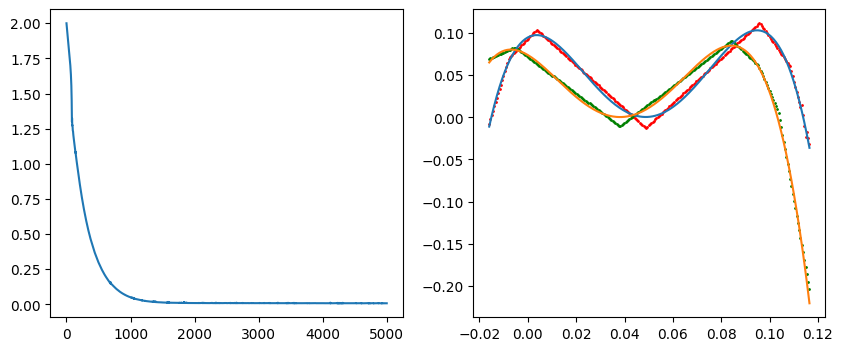

In [31]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 4) # this is done to increase width to 

# Create a figure and two axes objects
# Increase the figure size to accommodate wider plots
fig, (ax1, ax2) = plt.subplots(1, 2)

# plot loss
print ("last total_mean_loss ",total_mean_loss)
ax1.plot(losses)

# plot trained model
y = model(x)
yout = y.detach().numpy()
ax2.plot(x, ytest[:,0,0])
ax2.plot(x, ytest[:,0,1])
ax2.scatter(x, yout[:,0,0], color='red', s=1)
ax2.scatter(x, yout[:,0,1], color='green', s=1)

# Display the plot
plt.show()

In [593]:
# Save graph to a file
#!pip install torchviz
from torchviz import make_dot

# Generate a Graphviz object from the computation graph
graph = make_dot(loss, params=dict(model.named_parameters())) 

# Save the graph as a PDF or any other format if needed
#graph.render("model_TwoDSegmentNet_v1_graph")

'model_TwoDSegmentNet_v1_graph.pdf'

Text(0.5, 1.0, 'Are segment x in ascending order?')

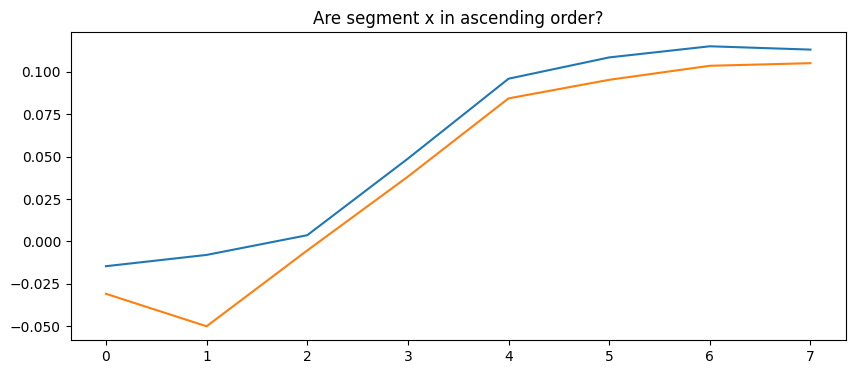

In [32]:
# Are x in ascending order?
plt.plot(np.arange(model_params[-1]['x'].shape[1]), model_params[-1]['x'][0])
plt.plot(np.arange(model_params[-1]['x'].shape[1]), model_params[-1]['x'][1])
plt.title("Are segment x in ascending order?")

In [33]:
model_params[-1]['x'][0]

tensor([-0.0147, -0.0080,  0.0036,  0.0488,  0.0960,  0.1085,  0.1151,  0.1131])

Text(0.5, 1.0, 'How the segments connect')

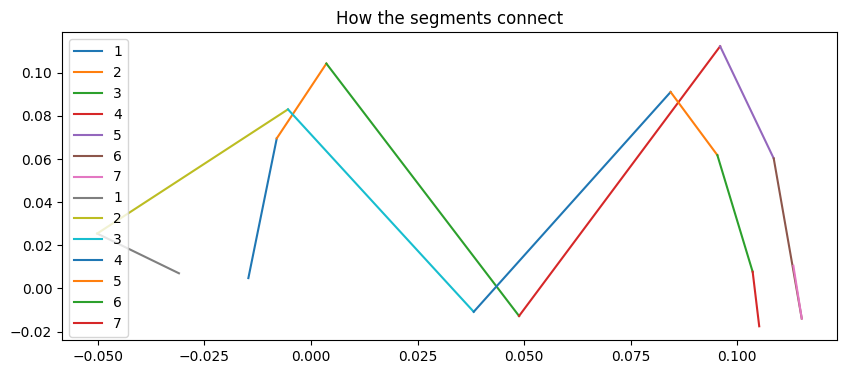

In [34]:
for seg in np.arange(model_params[-1]['x'].shape[1]-1):
 plt.plot(model_params[-1]['x'][0,seg:seg+2],model_params[-1]['y'][0,seg:seg+2],label=seg+1)    

for seg in np.arange(model_params[-1]['x'].shape[1]-1):
 plt.plot(model_params[-1]['x'][1,seg:seg+2],model_params[-1]['y'][1,seg:seg+2],label=seg+1)  
#plt.plot(model_params[-1]['x'],model_params[-1]['y']) 
plt.legend()
plt.title("How the segments connect")

# Show training as animation

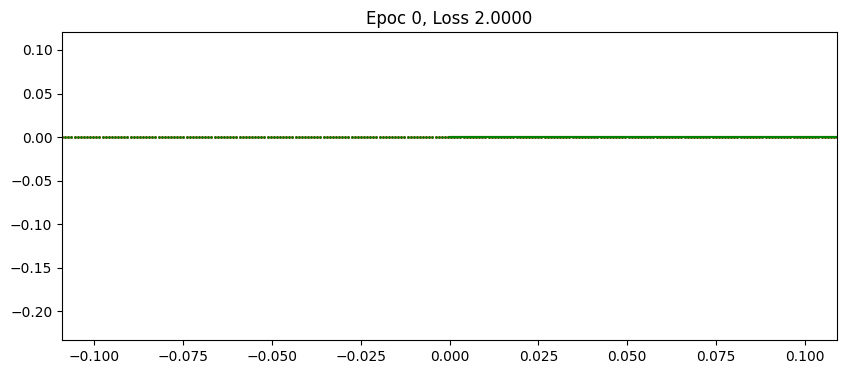

In [625]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
ax.set_xlim(x.min(), x.max())
ax.set_ylim(ytest.min()*.8, ytest.max()*1.2)
ax2.plot(x, ytest[:,0,0])
ax2.plot(x, ytest[:,0,1])
scatter = ax.scatter([], [], c='r',s=1)
scatter2 = ax.scatter([], [], c='g',s=1)
a1 = ax.plot([], [], c='r', linestyle="-")
a2 = ax.plot([], [], c='g', linestyle="-")

def animate(i):
    model.load_state_dict(model_params[i])
    px = model_params[i]['x']
    py = model_params[i]['y']
    a1[0].set_data(px[0], py[0])
    a2[0].set_data(px[1], py[1])

    #alternate plot
    with torch.no_grad():
        model.eval() # be sure to call model.eval() method before inferencing to set the dropout and batch normalization layers to evaluation mode. Failing to do this will yield inconsistent inference results.
        y = model(x)
    yout = y.detach().numpy()
    scatter.set_offsets(np.column_stack((x, yout[:,0,0])))
    scatter2.set_offsets(np.column_stack((x, yout[:,0,1])))
    ax.set_title(f"Epoc {i*1}, Loss {losses[10*(i)]:.4f}")
    return a

anim = FuncAnimation(fig, animate, frames=range(0,len(model_params)-1, 10))

In [626]:
from IPython.display import HTML
HTML(anim.to_jshtml())

# Debug Zone